In [31]:
import numpy as np
import pandas as pd
import os
from typing import List, Optional
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy


from results_processing import get_groups, get_dataset, flatten_results, get_top_models, plot_per_model_metrics, clean_model_names, pivot_per_dataset, plot_per_datasets, create_formatted_df, average_model_scores, add_per_model_means, combine_columns

# 1. Data post-processing

In [32]:
lcn_data = clean_model_names(pd.read_csv('LcnTotalResults.csv'))
mlp_data = clean_model_names(pd.read_csv('MlpTotalResults.csv'))
multi_data = clean_model_names(pd.read_csv('MultiModalResults.csv'))

data_groups = get_groups()

In [33]:
regression_cat_groups = data_groups['opml_reg_numcat_group']
regression_num_groups = data_groups['opml_reg_purnum_group']
classification_cat_groups = data_groups['opml_class_numcat_group']
classification_num_groups = data_groups['opml_class_purnum_group']


regression_groups = regression_cat_groups + regression_num_groups
classification_groups = classification_cat_groups + classification_num_groups

In [34]:
print(f'Total number of regression datasets: {len(regression_groups)}')
print(f'Total number of classificaitondatasets: {len(classification_groups)}')
print(f'Total number of datasets: {len(regression_groups) + len(classification_groups)}')

Total number of regression datasets: 36
Total number of classificaitondatasets: 23
Total number of datasets: 59


In [35]:
lcn_reg = get_dataset(lcn_data, regression_groups)
mlp_reg = get_dataset(mlp_data, regression_groups)
multi_reg = get_dataset(multi_data, regression_groups)

lcn_cls = get_dataset(lcn_data, classification_groups)
mlp_cls = get_dataset(mlp_data, classification_groups)
multi_cls = get_dataset(multi_data, classification_groups)

reg_datasets = pd.concat([lcn_reg, mlp_reg, multi_reg], ignore_index=True)
cls_datasets = pd.concat([lcn_cls, mlp_cls, multi_cls], ignore_index=True)

In [36]:
def combine_columns(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if col.startswith('val_metrics.'):
            corresponding_col = col.replace('val_metrics.', 'validate_metrics.')
            if corresponding_col in df.columns:
                df[col] = df[col].combine_first(df[corresponding_col])

    # Remove the 'validate_metrics...' columns after combining
    df.drop(columns=[col for col in df.columns if col.startswith('validate_metrics.')], inplace=True)

    return df

In [37]:
reg_results = flatten_results(reg_datasets, ['metrics'])
cls_results = flatten_results(cls_datasets, ['metrics'])

reg_results = combine_columns(reg_results)
cls_results = combine_columns(cls_results)


# reg_results.to_csv('regression_results.csv', index=False)
# cls_results.to_csv('classification_results.csv', index=False)
reg_results_separated = deepcopy(reg_results)
cls_results_separated = deepcopy(cls_results)

In [38]:
# Grouping the baseline models
group_multimodal = ['CatBoost', 'LGBM', 'SK_histGradBoost', 'XGBoost', 'SK_gradBoost']
rename = 'baseline'
reg_results['model'] = reg_results['model'].replace(group_multimodal, rename)
cls_results['model'] = cls_results['model'].replace(group_multimodal, rename)

In [39]:
print(reg_results.columns)
print(cls_results.columns)

Index(['dataset', 'hyperparameters', 'model', 'train_loss', 'epoch',
       'val_loss', 'test_loss', 'epoch_time', 'train_metrics.RMSE',
       'train_metrics.r2_score', 'train_metrics.se_quant', 'val_metrics.RMSE',
       'val_metrics.r2_score', 'val_metrics.se_quant', 'test_metrics.RMSE',
       'test_metrics.r2_score', 'test_metrics.se_quant'],
      dtype='object')
Index(['dataset', 'hyperparameters', 'model', 'train_loss', 'val_loss',
       'test_loss', 'epoch', 'epoch_time', 'train_metrics.accuracy_score',
       'train_metrics.roc_auc_score', 'train_metrics.confusion_matrix',
       'val_metrics.accuracy_score', 'val_metrics.roc_auc_score',
       'val_metrics.confusion_matrix', 'test_metrics.accuracy_score',
       'test_metrics.roc_auc_score', 'test_metrics.confusion_matrix'],
      dtype='object')


# 2. Analyzing results

# 2.1 Accuracy:

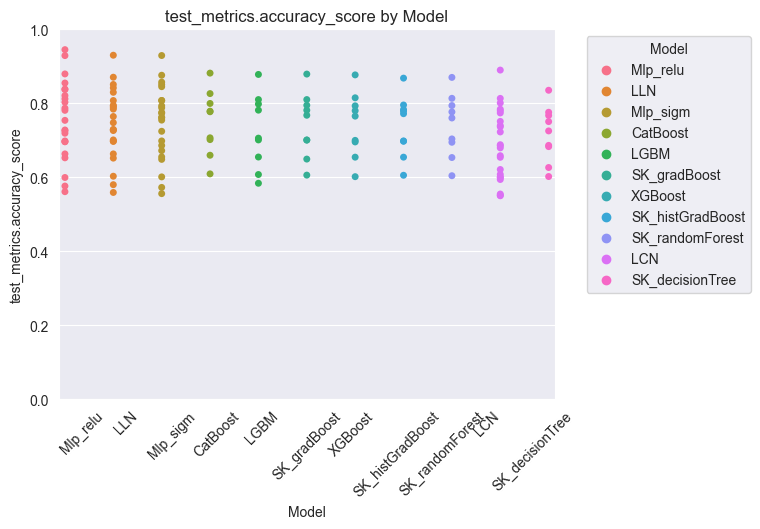

In [87]:
top_acc_sep = get_top_models(cls_results_separated, 'val_metrics.accuracy_score')
plot_per_model_metrics(top_acc_sep, 'test_metrics.accuracy_score')

# 2.2 Roc_auc_score

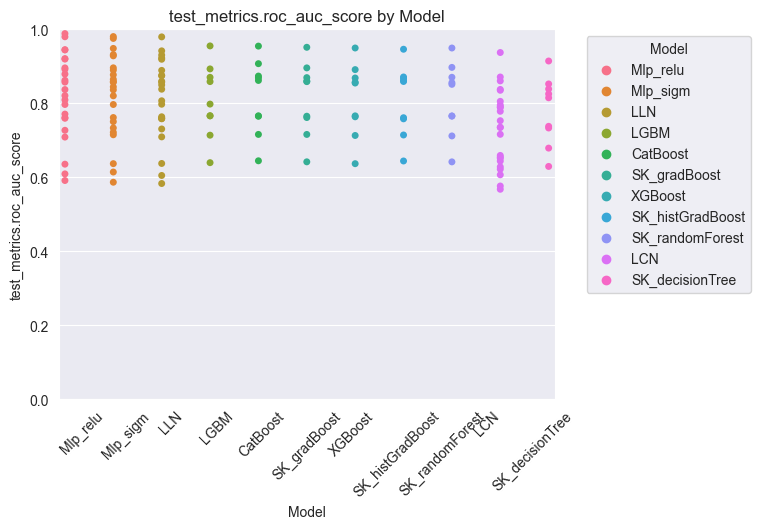

In [86]:
top_roc_sep = get_top_models(cls_results_separated, 'val_metrics.roc_auc_score')
plot_per_model_metrics(top_roc_sep, 'test_metrics.roc_auc_score')

# 2.3 RMSE

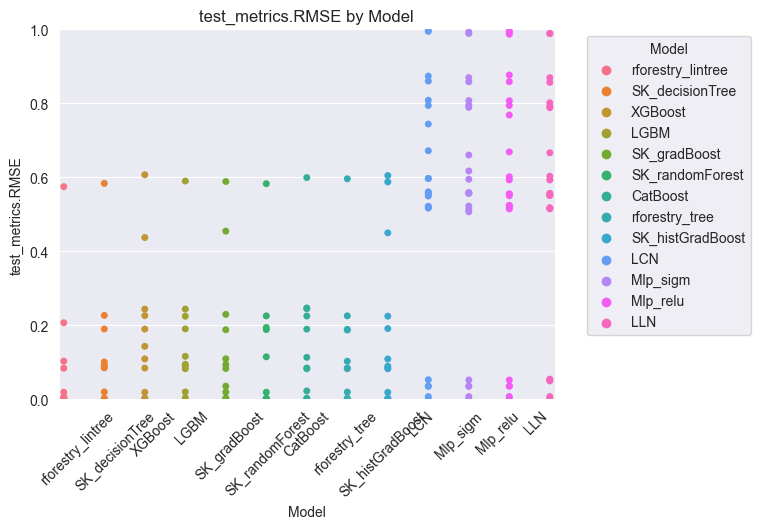

In [42]:
top_rmse_sep = get_top_models(reg_results_separated, 'val_metrics.RMSE', highest = False)
plot_per_model_metrics(top_rmse_sep, 'test_metrics.RMSE', scale = [0, 0.6])

# 2.4 R2 score

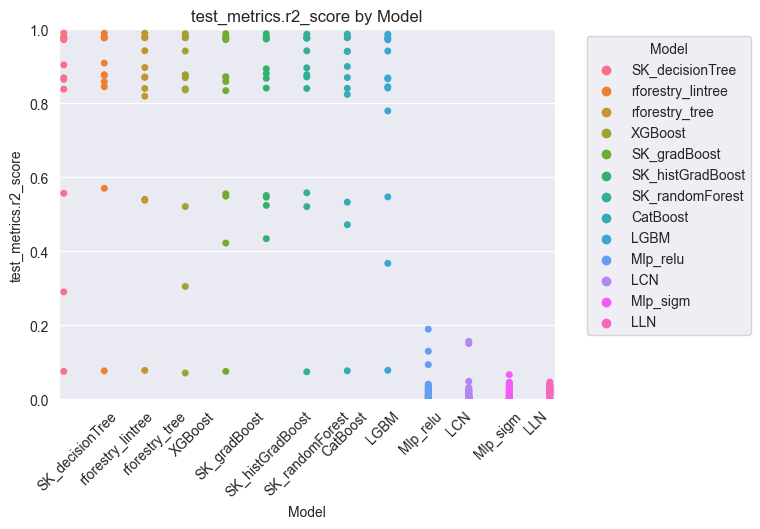

In [43]:
top_r2_sep = get_top_models(reg_results_separated, 'val_metrics.r2_score')
plot_per_model_metrics(top_r2_sep, 'test_metrics.r2_score')

# 3 Classification datasets

# 3.1 Accuracy Score

# 3.1.1 Top 1 performing model

In [44]:
enough_data = ['334-361282', '334-361285', '337-361055', '334-361283', '337-361066', '337-361061', '337-361273', '337-361277', '337-361275']
top_acc_score = get_top_models(cls_results, 'val_metrics.accuracy_score')
top_acc_per_dataset = pivot_per_dataset(top_acc_score, 'test_metrics.accuracy_score')
top_acc_per_dataset = top_acc_per_dataset[['model'] + enough_data]
top_acc_per_dataset.to_csv('saved_results/top_acc_per_dataset.csv')

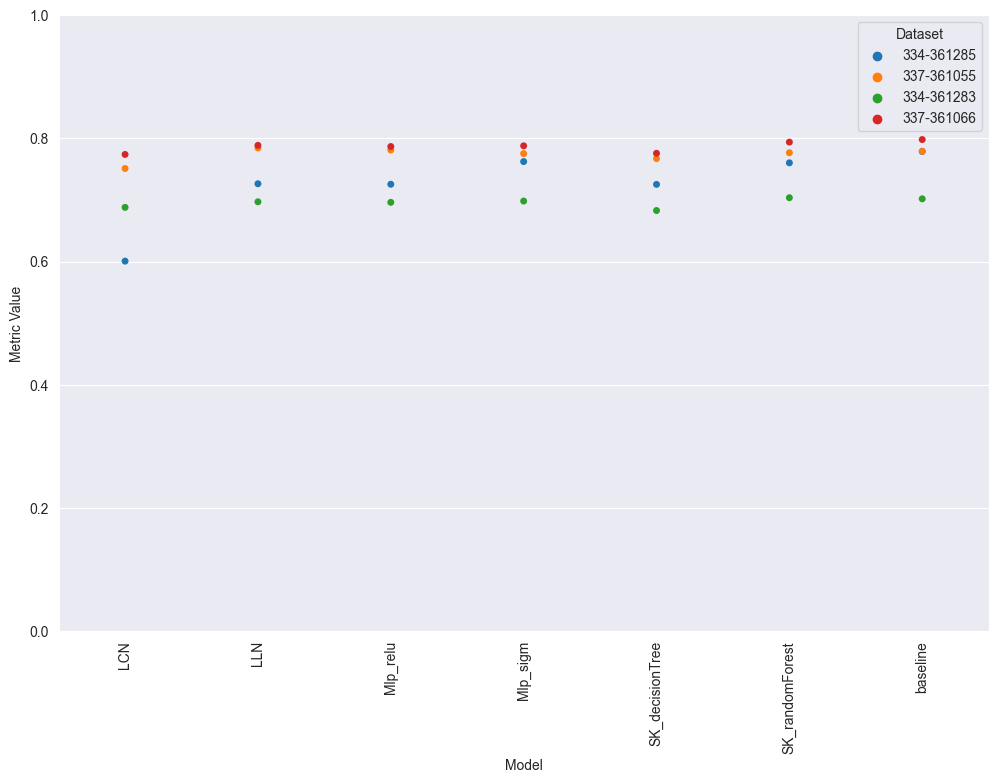

In [45]:
to_plot = enough_data[1:5]
plot_per_datasets(top_acc_per_dataset, to_plot, scale = True)

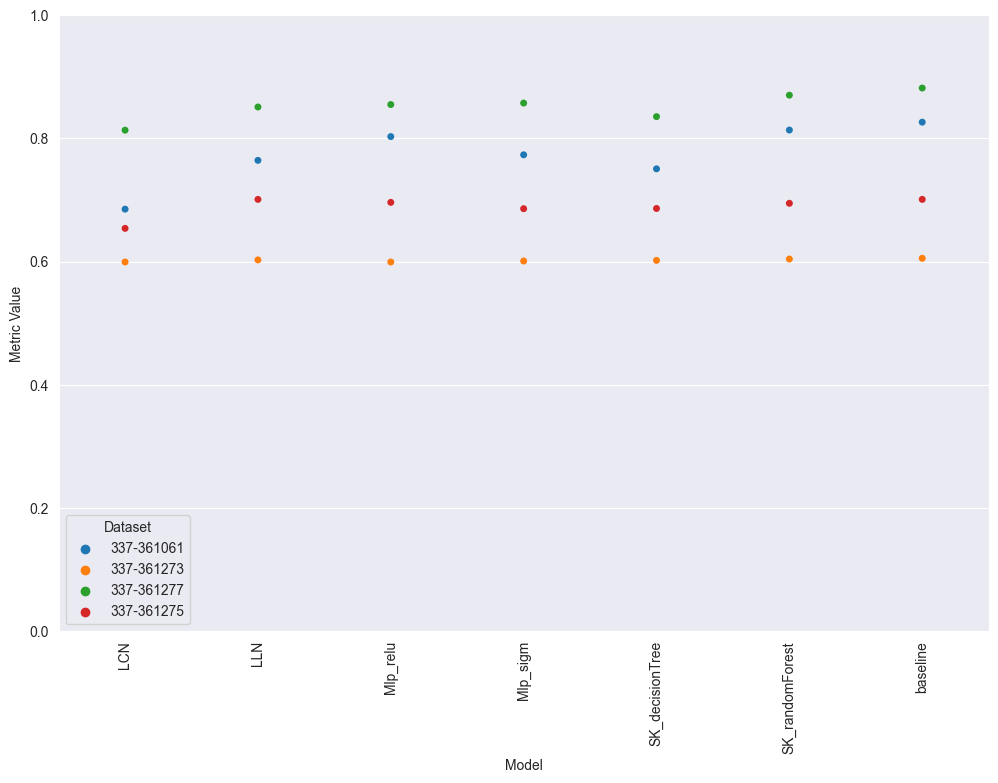

In [46]:
to_plot = enough_data[5:]
plot_per_datasets(top_acc_per_dataset, to_plot, scale = True)

In [47]:
per_dataset_top_acc = create_formatted_df(top_acc_per_dataset)
per_dataset_top_acc.to_csv('saved_results/per_dataset_top_acc.csv')

# 3.2 Top 5 performing models

In [48]:
enough_data = ['334-361282', '334-361285', '337-361055', '334-361283', '337-361066', '337-361061', '337-361273', '337-361277', '337-361275']
top5_acc_score = get_top_models(cls_results, 'val_metrics.accuracy_score', top = 5)
top5_acc_score = average_model_scores(top5_acc_score, 'test_metrics.accuracy_score')
top5_acc_per_dataset = pivot_per_dataset(top5_acc_score, 'test_metrics.accuracy_score')
top5_acc_per_dataset = top5_acc_per_dataset[['model'] + enough_data]
# top5_acc_per_dataset.to_csv('saved_results/top5_acc_per_dataset.csv')

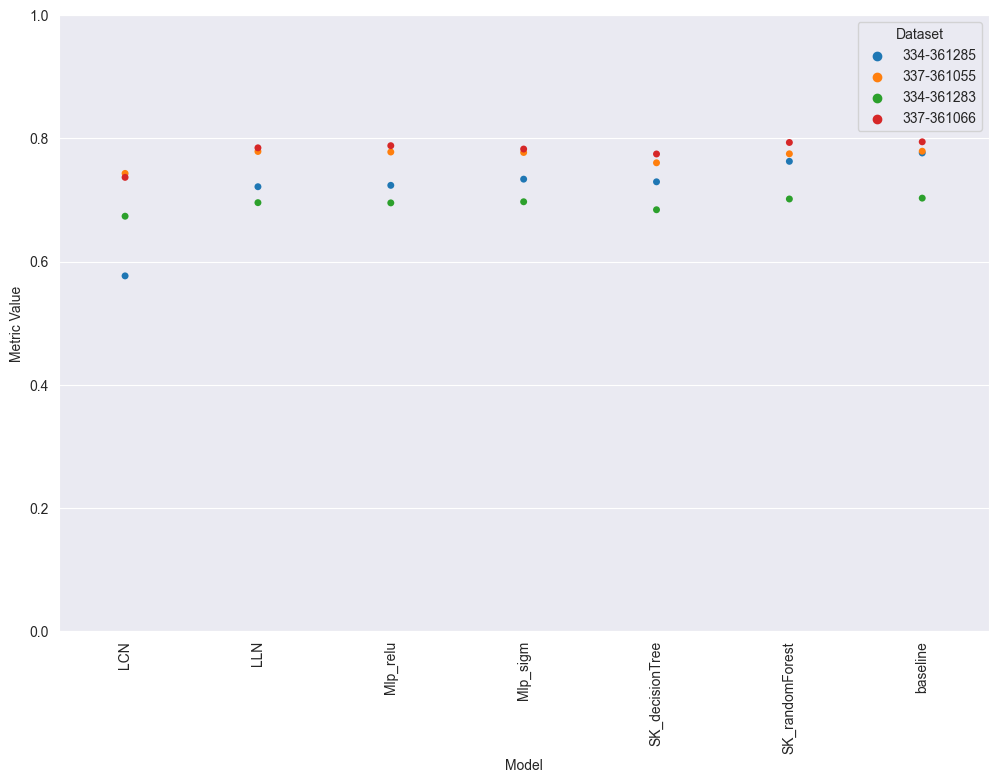

In [49]:
to_plot = enough_data[1:5]
plot_per_datasets(top5_acc_per_dataset, to_plot, scale = True)

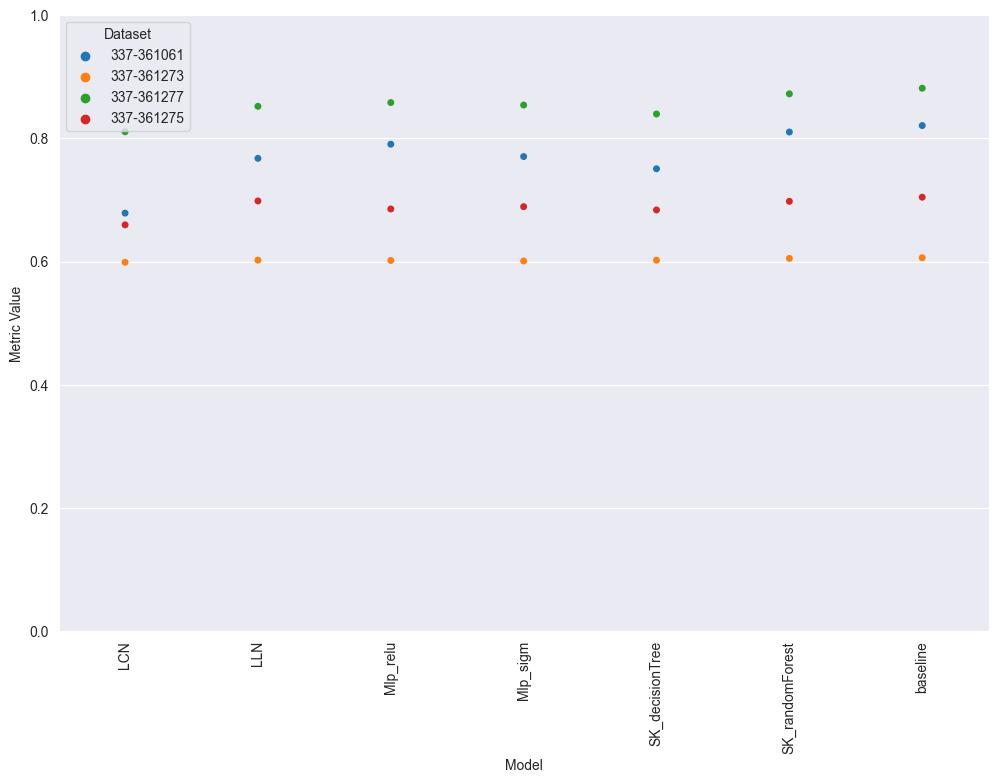

In [50]:
to_plot = enough_data[5:]
plot_per_datasets(top5_acc_per_dataset, to_plot, scale = True)

# 3.3 Top 15 performing models

In [51]:
enough_data = ['334-361282', '334-361285', '337-361055', '334-361283', '337-361066', '337-361061', '337-361273', '337-361277', '337-361275']
top15_acc_score = get_top_models(cls_results, 'val_metrics.accuracy_score', top = 15)
top15_acc_score = average_model_scores(top15_acc_score, 'test_metrics.accuracy_score')
top15_acc_per_dataset = pivot_per_dataset(top15_acc_score, 'test_metrics.accuracy_score')
top15_acc_per_dataset = top15_acc_per_dataset[['model'] + enough_data]
top15_acc_per_dataset.to_csv('saved_results/top15_acc_per_dataset.csv')

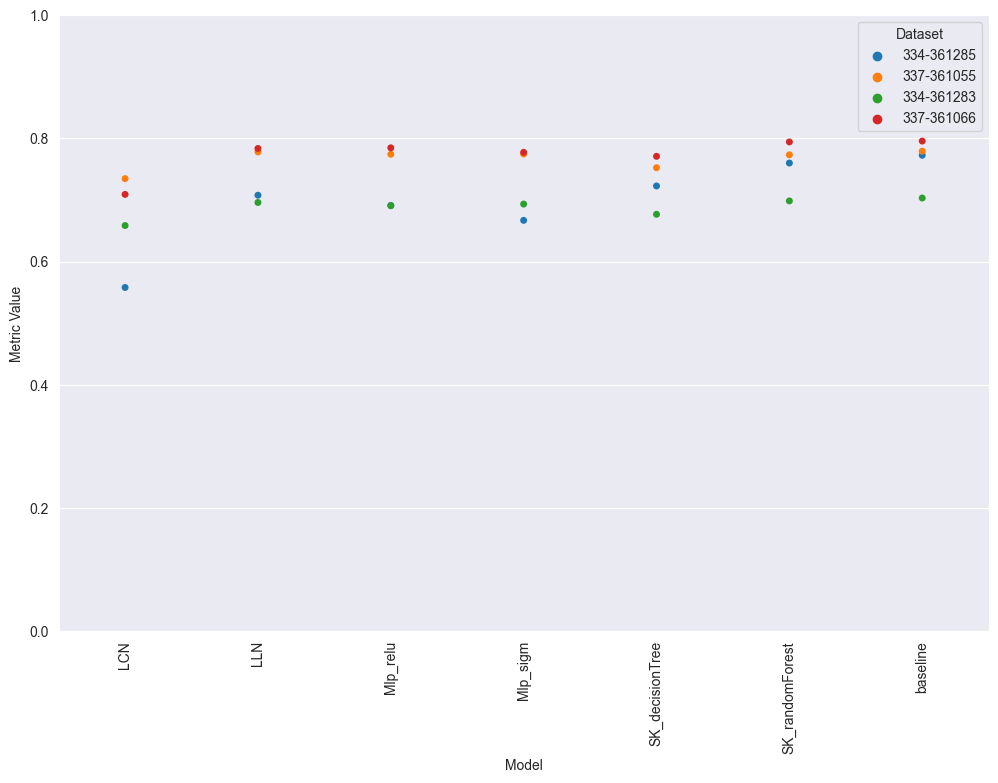

In [52]:
to_plot = enough_data[1:5]
plot_per_datasets(top15_acc_per_dataset, to_plot, scale = True)

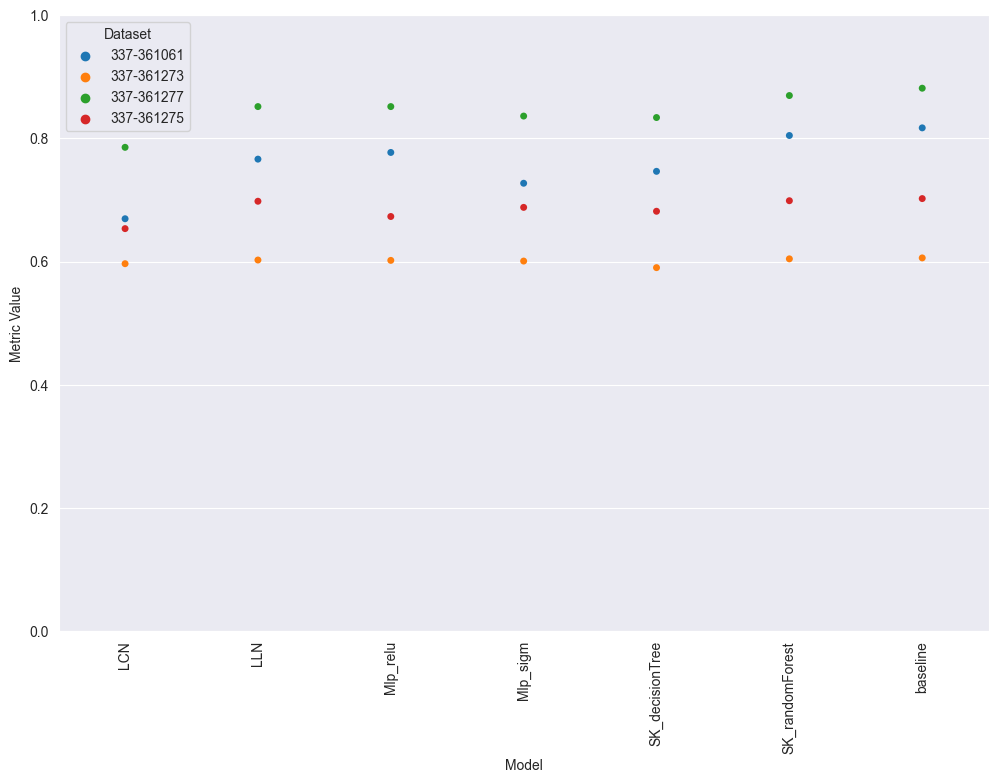

In [53]:
to_plot = enough_data[5:]
plot_per_datasets(top15_acc_per_dataset, to_plot, scale = True)

In [54]:
per_dataset_top15_acc = create_formatted_df(top15_acc_per_dataset)
per_dataset_top15_acc.to_csv('saved_results/per_dataset_top15_acc.csv')

# 3.2 Per-dataset roc auc score

# 3.2.1 Top 1 performing model

In [55]:
enough_data = ['334-361282', '334-361285', '337-361055', '334-361283', '337-361066', '337-361061', '337-361273', '337-361277', '337-361275']
top_roc_score = get_top_models(cls_results, 'val_metrics.roc_auc_score')
top_roc_per_dataset = pivot_per_dataset(top_roc_score, 'test_metrics.roc_auc_score')
top_roc_per_dataset = top_roc_per_dataset[['model'] + enough_data]
top_roc_per_dataset.to_csv('saved_results/top_roc_per_dataset.csv')

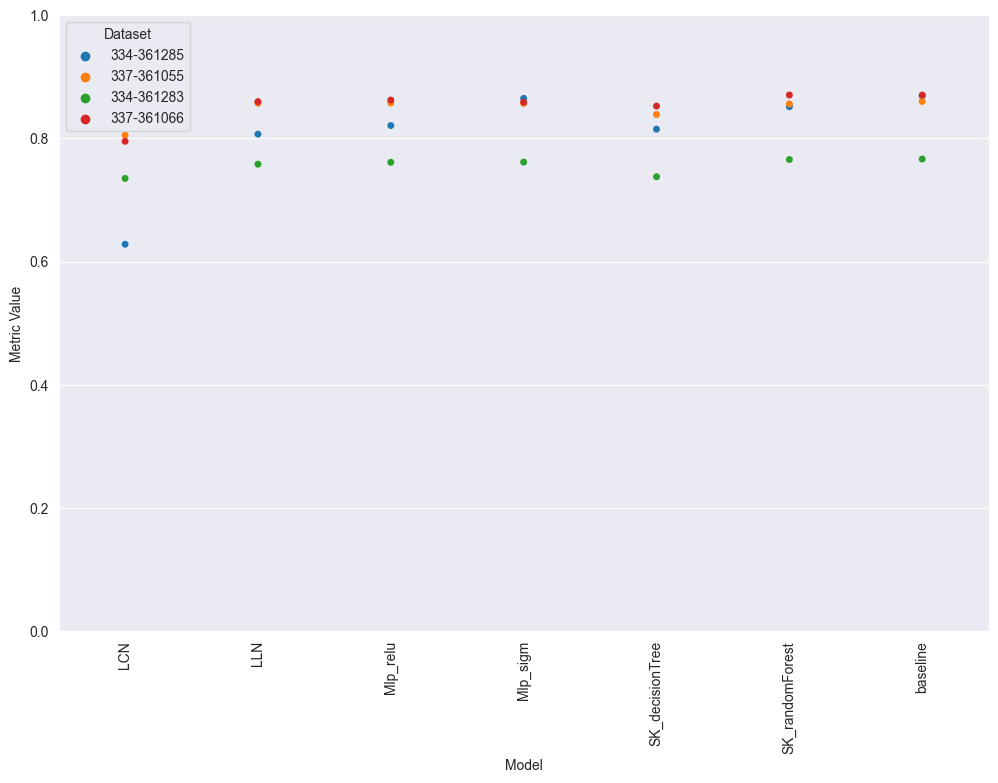

In [56]:
to_plot = enough_data[1:5]
plot_per_datasets(top_roc_per_dataset, to_plot, scale = True)

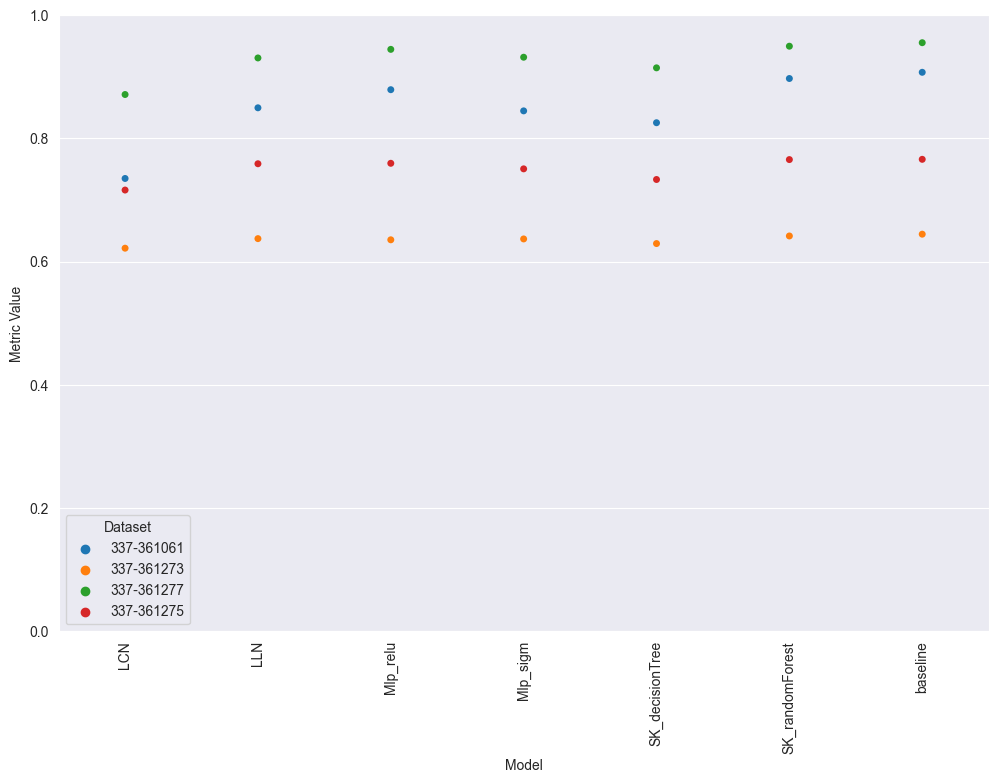

In [57]:
to_plot = enough_data[5:]
plot_per_datasets(top_roc_per_dataset, to_plot, scale = True)

In [58]:
per_dataset_top_roc = create_formatted_df(top_roc_per_dataset)
per_dataset_top_roc.to_csv('saved_results/per_dataset_top_roc.csv')

# 3.2.2 Top 15 performing model

In [59]:
enough_data = ['334-361282', '334-361285', '337-361055', '334-361283', '337-361066', '337-361061', '337-361273', '337-361277', '337-361275']
top15_roc_score = get_top_models(cls_results, 'val_metrics.roc_auc_score', top = 15)
top15_roc_score = average_model_scores(top15_roc_score, 'test_metrics.roc_auc_score')
top15_roc_per_dataset = pivot_per_dataset(top15_roc_score, 'test_metrics.roc_auc_score')
top15_roc_per_dataset = top15_roc_per_dataset[['model'] + enough_data]
top15_roc_per_dataset.to_csv('saved_results/top15_roc_per_dataset.csv')

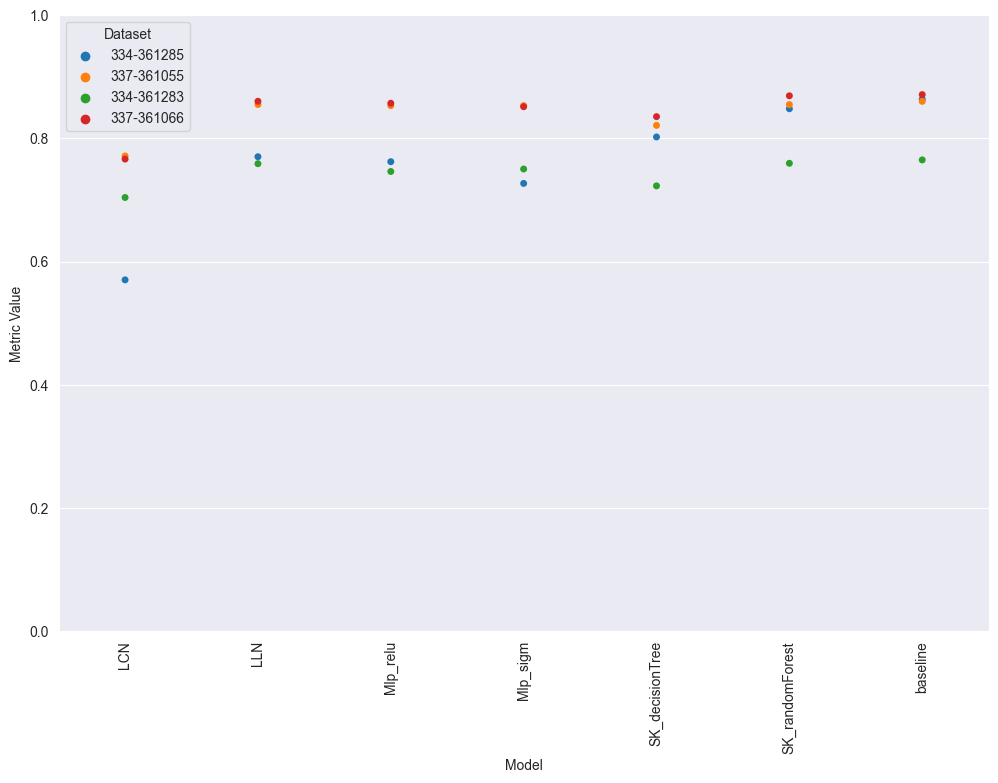

In [60]:
to_plot = enough_data[1:5]
plot_per_datasets(top15_roc_per_dataset, to_plot, scale = True)

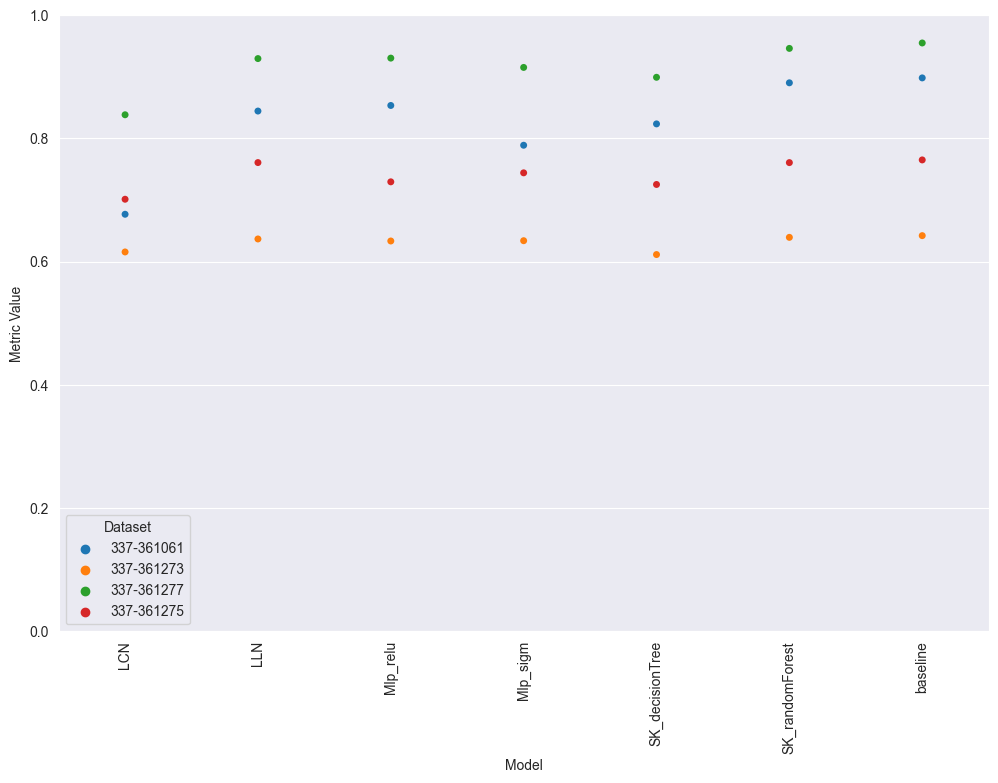

In [61]:
to_plot = enough_data[5:]
plot_per_datasets(top15_roc_per_dataset, to_plot, scale = True)

In [62]:
per_dataset_top15_roc = create_formatted_df(top15_roc_per_dataset)
per_dataset_top15_roc.to_csv('saved_results/per_dataset_top15_roc.csv')

# 3.3 Categorical features

In [74]:
lcn_cat = get_dataset(lcn_data, classification_cat_groups)
mlp_cat = get_dataset(mlp_data, classification_cat_groups)
multi_cat = get_dataset(multi_data, classification_cat_groups)

lcn_num = get_dataset(lcn_data, classification_num_groups)
mlp_num = get_dataset(mlp_data, classification_num_groups)
multi_num = get_dataset(multi_data, classification_num_groups)

cls_cat_datasets = pd.concat([lcn_cat, mlp_cat, multi_cat], ignore_index=True)
cls_num_datasets = pd.concat([lcn_num, mlp_num, multi_num], ignore_index=True)

cls_cat = flatten_results(cls_cat_datasets, ['metrics'])
cls_num = flatten_results(cls_num_datasets, ['metrics'])

cls_cat = combine_columns(cls_cat)
cls_num = combine_columns(cls_num)

In [75]:
top_cat_roc_score = get_top_models(cls_cat, 'val_metrics.roc_auc_score')
top_cat_roc_per_dataset = pivot_per_dataset(top_cat_roc_score, 'test_metrics.roc_auc_score')

top_num_roc_score = get_top_models(cls_num, 'val_metrics.roc_auc_score')
top_num_roc_per_dataset = pivot_per_dataset(top_num_roc_score, 'test_metrics.roc_auc_score')

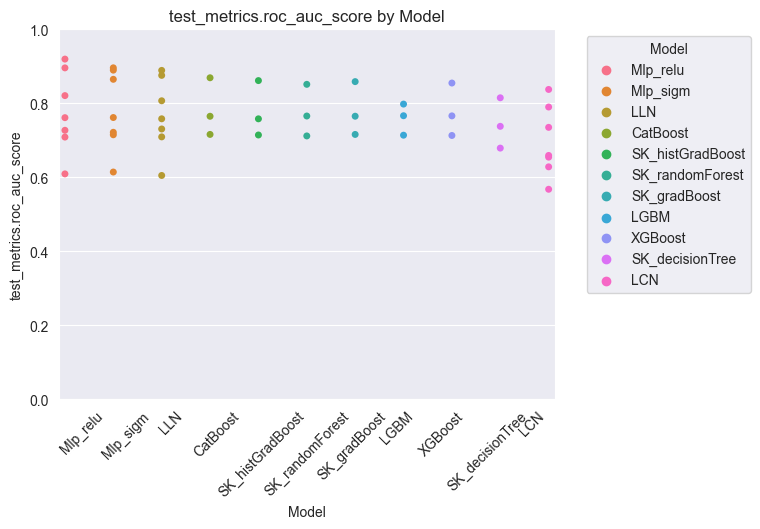

In [76]:
plot_per_model_metrics(top_cat_roc_score, 'test_metrics.roc_auc_score')

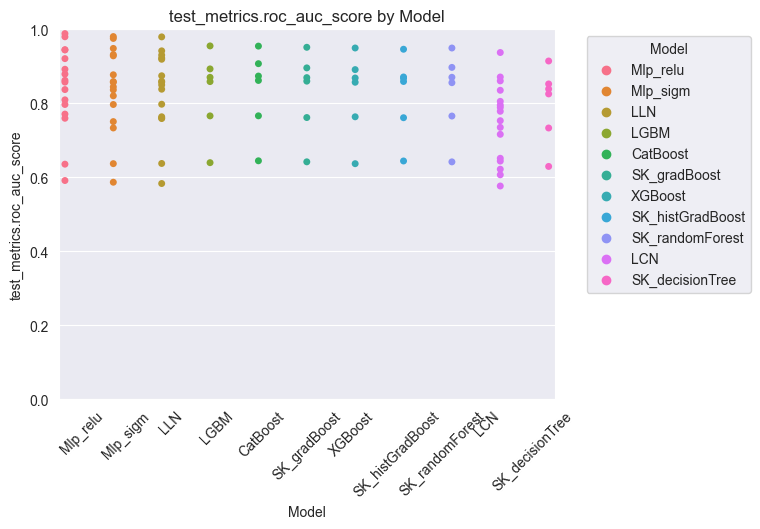

In [77]:
plot_per_model_metrics(top_num_roc_score, 'test_metrics.roc_auc_score')

In [78]:
top_cat_roc_per_dataset = add_per_model_means(top_cat_roc_per_dataset)
top_num_roc_per_dataset = add_per_model_means(top_num_roc_per_dataset)
top_cat_roc_per_dataset.to_csv('saved_results/top_cat_roc_per_dataset.csv')
top_num_roc_per_dataset.to_csv('saved_results/top_num_roc_per_dataset.csv')

In [79]:
mean_performance = (top_cat_roc_per_dataset['mean'] - top_num_roc_per_dataset['mean'])

# Create a DataFrame
mean_cls_catnum_performance_df = pd.DataFrame({
    'model': top_cat_roc_per_dataset['model'],  # Assuming both DataFrames have the same 'model' column
    'mean_performance': mean_performance
})

In [80]:
mean_cls_catnum_performance_df.to_csv('mean_cls_catnum.csv')

In [70]:
mlp_cat_datasets = flatten_results(mlp_cat, ['metrics', 'hyperparameters'])

/Users/bartoszgawin/Desktop/ML/RoundtableML/non-homogenous-paper/results/results_processing.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
/Users/bartoszgawin/Desktop/ML/RoundtableML/non-homogenous-paper/results/results_processing.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [71]:
placeholder = 'None'
mlp_cat_datasets['embd_size'].fillna(placeholder, inplace=True)

mlp_cat_datasets_sorted = mlp_cat_datasets.sort_values(
    by=['dataset', 'model', 'embd_size', 'val_metrics.roc_auc_score'],
    ascending=[True, True, True, False]
)

# Drop duplicates to keep only the rows with the highest 'val_metrics.roc_auc_score' for each group
top_mlp_cat_embd_size = mlp_cat_datasets_sorted.drop_duplicates(
    subset=['dataset', 'model', 'embd_size'],
    keep='first'
).reset_index(drop=True)

filtered_df = top_mlp_cat_embd_size[top_mlp_cat_embd_size['model'].isin(['Mlp_relu', 'Mlp_sigm'])]

# Calculate mean of 'test_metrics.roc_auc_score' grouped by 'embd_size' and 'model'
grouped_df = filtered_df.groupby(['embd_size', 'model'])['test_metrics.roc_auc_score'].mean().reset_index()

# Create a pivot table for better presentation
pivot_df = pd.pivot_table(grouped_df, values='test_metrics.roc_auc_score', index=['embd_size'], columns=['model']).reset_index()
pivot_df.columns.name = None

In [72]:
pivot_df.to_csv('saved_results/embedding_performance_classification.csv')

In [73]:
pivot_df

,embd_size,Mlp_relu,Mlp_sigm
0,64,0.745897,0.737206
1,128,0.737051,0.727157
2,256,0.752308,0.745829
3,None,0.775770,0.779548
4,sqrt,0.745512,0.750164


# 4. Regression datasets

# 4.1 RMSE

# 4.1.1 Top 1 performing model

In [84]:
# enough_data = ['334-361282', '334-361285', '337-361055', '334-361283', '337-361066', '337-361061', '337-361273', '337-361277', '337-361275']
top_rmse_score = get_top_models(reg_results, 'val_metrics.RMSE', highest = False)
top_rmse_per_dataset = pivot_per_dataset(top_rmse_score, 'test_metrics.RMSE')
top_rmse_per_dataset.to_csv('saved_results/top_rmse_per_dataset.csv')
per_dataset_top_rmse = create_formatted_df(top_rmse_per_dataset, highest = False)
per_dataset_top_rmse.to_csv('saved_results/per_dataset_top_rmse.csv')

# 4.1.2 Top 15 performing models

Index(['dataset', 'hyperparameters', 'model', 'train_loss', 'epoch',
       'val_loss', 'test_loss', 'epoch_time', 'train_metrics.RMSE',
       'train_metrics.r2_score', 'train_metrics.se_quant', 'val_metrics.RMSE',
       'val_metrics.r2_score', 'val_metrics.se_quant', 'test_metrics.RMSE',
       'test_metrics.r2_score', 'test_metrics.se_quant'],
      dtype='object')